            MSFT_Open  MSFT_Ot-1  MSFT_Ot-2  MSFT_Close  MSFT_Ct-1  MSFT_Ct-2  AAPL_Open  AAPL_Ot-1  AAPL_Ot-2  AAPL_Close  AAPL_Ct-1  AAPL_Ct-2
Date                                                                                                                                            
2018-10-25  -0.017157   0.005939  -0.014179    0.058444  -0.053469  -0.013956  -0.021968   0.031367  -0.018017    0.021898  -0.034302   0.009427
2018-10-26  -0.008071  -0.017157   0.005939   -0.012373   0.058444  -0.053469  -0.008314  -0.021968   0.031367   -0.015924   0.021898  -0.034302
2018-10-29   0.022897  -0.008071  -0.017157   -0.029076  -0.012373   0.058444   0.015239  -0.008314  -0.021968   -0.018770  -0.015924   0.021898
2018-10-30  -0.041162   0.022897  -0.008071   -0.001155  -0.029076  -0.012373  -0.036681   0.015239  -0.008314    0.004994  -0.018770  -0.015924
2018-10-31   0.017172  -0.041162   0.022897    0.029692  -0.001155  -0.029076   0.027137  -0.036681   0.015239    0.026067   0.004

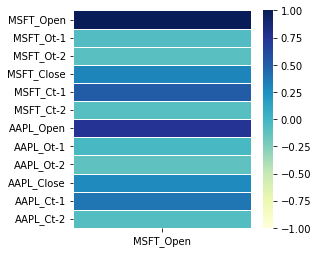

In [9]:
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import pandas_datareader  as pdr

# Show all columns.
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# Do not show warning.
pd.options.mode.chained_assignment = None  # default='warn'

##################################################################
# CONFIGURATION SECTION
NUM_DAYS        = 1200
NUM_TIME_STEPS  = 2
TEST_DAYS       = 30
##################################################################

def getStock(stk, ttlDays):
    numDays = int(ttlDays)
    dt      = datetime.date.today()
    dtPast  = dt + datetime.timedelta(days=-numDays)
    df      = pdr.get_data_yahoo(stk,
                                 start=datetime.datetime(dtPast.year, dtPast.month,
                                                         dtPast.day),
                                 end  =datetime.datetime(dt.year, dt.month, dt.day))
    return df

# Creates time shifted columns for as many time steps needed.
def backShiftColumns(df, originalColName, numTimeSteps):
    dfNew  = df[[originalColName]].pct_change()

    for i in range(1, numTimeSteps + 1):
        newColName       = originalColName[0] + 't-' + str(i)
        dfNew[newColName]= dfNew[originalColName].shift(periods=i)
    return dfNew

def prepareStockDf(stockSymbol, columns):
    df = getStock(stockSymbol, NUM_DAYS)

    # Create data frame with back shift columns for all features of interest.
    mergedDf = pd.DataFrame()
    for i in range(0, len(columns)):
        backShiftedDf  = backShiftColumns(df, columns[i], NUM_TIME_STEPS)
        if(i==0):
            mergedDf = backShiftedDf
        else:
            mergedDf = mergedDf.merge(backShiftedDf, left_index=True,
                                      right_index=True)

    newColumns = list(mergedDf.keys())

    # Append stock symbol to column names.
    for i in range(0, len(newColumns)):
        mergedDf.rename(columns={newColumns[i]: stockSymbol +
                                                "_" + newColumns[i]}, inplace=True)

    return mergedDf

columns  = ['Open', 'Close']
msftDf   = prepareStockDf('MSFT', columns)
aaplDf   = prepareStockDf('AAPL', columns)
mergedDf = msftDf.merge(aaplDf, left_index=True, right_index=True)
mergedDf = mergedDf.dropna()
print(mergedDf)

import seaborn as sns

corr = mergedDf.corr()
plt.figure(figsize = (4,4))
ax = sns.heatmap(corr[['MSFT_Open']],
                 linewidth=0.5, vmin=-1,
                 vmax=1, cmap="YlGnBu")
plt.show()

             MSFT_Open   MSFT_Ot-1   MSFT_Ot-2  MSFT_Close   MSFT_Ct-1   MSFT_Ct-2   AAPL_Open   AAPL_Ot-1   AAPL_Ot-2  AAPL_Close   AAPL_Ct-1   AAPL_Ct-2
Date                                                                                                                                                      
2018-10-24  108.410004  107.769997  109.320000  102.320000  108.099998  109.629997   55.650002   53.957500   54.947498   53.772499   55.682499   55.162498
2018-10-25  106.550003  108.410004  107.769997  108.300003  102.320000  108.099998   54.427502   55.650002   53.957500   54.950001   53.772499   55.682499
2018-10-26  105.690002  106.550003  108.410004  106.959999  108.300003  102.320000   53.974998   54.427502   55.650002   54.075001   54.950001   53.772499
2018-10-29  108.110001  105.690002  106.550003  103.849998  106.959999  108.300003   54.797501   53.974998   54.427502   53.060001   54.075001   54.950001
2018-10-30  103.660004  108.110001  105.690002  103.730003  103.849998

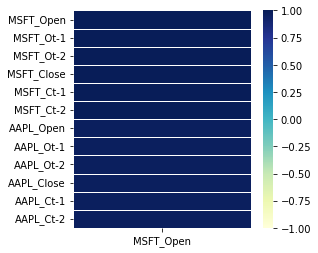

                            OLS Regression Results                            
Dep. Variable:              MSFT_Open   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 8.044e+05
Date:                Thu, 03 Feb 2022   Prob (F-statistic):               0.00
Time:                        00:51:52   Log-Likelihood:                -1703.0
No. Observations:                 795   AIC:                             3410.
Df Residuals:                     793   BIC:                             3419.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2250      0.227      0.992      0.3

/opt/homebrew/anaconda3/envs/COMP-3948/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


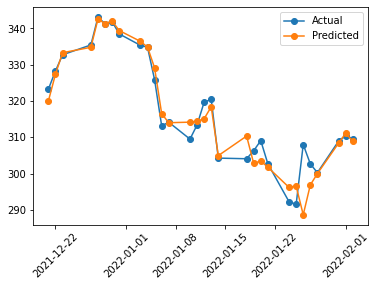

In [19]:
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import pandas_datareader  as pdr

# Show all columns.
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# Do not show warning.
pd.options.mode.chained_assignment = None  # default='warn'

##################################################################
# CONFIGURATION SECTION
NUM_DAYS        = 1200
NUM_TIME_STEPS  = 2
TEST_DAYS       = 30
##################################################################

def getStock(stk, ttlDays):
    numDays = int(ttlDays)
    dt      = datetime.date.today()
    dtPast  = dt + datetime.timedelta(days=-numDays)
    df      = pdr.get_data_yahoo(stk,
                                 start=datetime.datetime(dtPast.year, dtPast.month,
                                                         dtPast.day),
                                 end  =datetime.datetime(dt.year, dt.month, dt.day))
    return df

# Creates time shifted columns for as many time steps needed.
def backShiftColumns(df, originalColName, numTimeSteps):
    dfNew  = df[[originalColName]]

    for i in range(1, numTimeSteps + 1):
        newColName       = originalColName[0] + 't-' + str(i)
        dfNew[newColName]= dfNew[originalColName].shift(periods=i)
    return dfNew

def prepareStockDf(stockSymbol, columns):
    df = getStock(stockSymbol, NUM_DAYS)

    # Create data frame with back shift columns for all features of interest.
    mergedDf = pd.DataFrame()
    for i in range(0, len(columns)):
        backShiftedDf  = backShiftColumns(df, columns[i], NUM_TIME_STEPS)
        if(i==0):
            mergedDf = backShiftedDf
        else:
            mergedDf = mergedDf.merge(backShiftedDf, left_index=True,
                                      right_index=True)

    newColumns = list(mergedDf.keys())

    # Append stock symbol to column names.
    for i in range(0, len(newColumns)):
        mergedDf.rename(columns={newColumns[i]: stockSymbol +
                                                "_" + newColumns[i]}, inplace=True)

    return mergedDf

columns  = ['Open', 'Close']
msftDf   = prepareStockDf('MSFT', columns)
aaplDf   = prepareStockDf('AAPL', columns)
mergedDf = msftDf.merge(aaplDf, left_index=True, right_index=True)
mergedDf = mergedDf.dropna()
print(mergedDf)

import seaborn as sns

corr = mergedDf.corr()
plt.figure(figsize = (4,4))
ax = sns.heatmap(corr[['MSFT_Open']],
                 linewidth=0.5, vmin=-1,
                 vmax=1, cmap="YlGnBu")
plt.show()

xfeatures = ['MSFT_Ct-1']
X = mergedDf[xfeatures]
y = mergedDf[['MSFT_Open']]

# Add intercept for OLS regression.
import statsmodels.api       as sm
X = sm.add_constant(X)

# Split into test and train sets. The test data must be
# the latest data range.
lenData = len(X)
X_train = X[0:lenData-TEST_DAYS]
y_train = y[0:lenData-TEST_DAYS]
X_test  = X[lenData-TEST_DAYS:]
y_test  = y[lenData-TEST_DAYS:]

# Model and make predictions.
model       = sm.OLS(y_train, X_train).fit()
print(model.summary())
predictions = model.predict(X_test)

# Show RMSE and plot the data.
from sklearn  import metrics
import numpy as np
print('Root Mean Squared Error:',
      np.sqrt(metrics.mean_squared_error(y_test, predictions)))

plt.plot(y_test, label='Actual', marker='o')
plt.plot(predictions, label='Predicted', marker='o')
plt.xticks(rotation=45)
plt.legend(loc='best')
plt.show()

             meantemp   humidity  wind_speed  meanpressure
date                                                      
2017-01-01  15.913043  85.869565    2.743478     59.000000
2017-01-02  18.500000  77.222222    2.894444   1018.277778
2017-01-03  17.111111  81.888889    4.016667   1018.333333
2017-01-04  18.700000  70.050000    4.545000   1015.700000
2017-01-05  18.388889  74.944444    3.300000   1014.333333
...               ...        ...         ...           ...
2017-04-20  34.500000  27.500000    5.562500    998.625000
2017-04-21  34.250000  39.375000    6.962500    999.875000
2017-04-22  32.900000  40.900000    8.890000   1001.600000
2017-04-23  32.875000  27.500000    9.962500   1002.125000
2017-04-24  32.000000  27.142857   12.157143   1004.142857

[114 rows x 4 columns]
                            OLS Regression Results                            
Dep. Variable:               meantemp   R-squared:                       0.905
Model:                            OLS   Adj. R-squa

/opt/homebrew/anaconda3/envs/COMP-3948/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


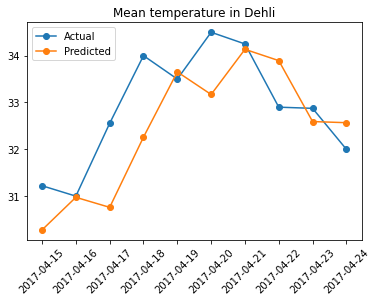

In [20]:
import matplotlib.pyplot as plt
import pandas            as pd
import numpy             as np
import statsmodels.api   as sm
from sklearn.preprocessing import MinMaxScaler

# Show all columns.
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# Do not show warning.
pd.options.mode.chained_assignment = None

# Load the data.
PATH = '../datasets/'
FILE = 'DailyDelhiClimateTest.csv'
df   = pd.read_csv(PATH + FILE, parse_dates=['date'], index_col='date')
print(df)

# Create back-shifted columns for an attribute.
def addBackShiftedColumns(df, colName, timeLags):
    for i in range(1, timeLags+1):
        newColName = colName + "_t-" + str(i)
        df[newColName] = df[colName].shift(i)
    return df

# Build dataframe for modelling.
columns = ['meantemp', 'humidity', 'wind_speed', 'meanpressure']
modelDf = df.copy()
NUM_TIME_STEPS = 3
for i in range(0, len(columns)):
    modelDf = addBackShiftedColumns(modelDf, columns[i],
                                    NUM_TIME_STEPS)
modelDf = modelDf.dropna()
y = modelDf[['meantemp']]
X = modelDf[[ 'meantemp_t-1']]

# Add intercept for OLS regression.
X         = sm.add_constant(X)
TEST_DAYS = 10

# Split into test and train sets. The test data includes
# the latest values in the data.
lenData = len(X)
X_train = X[0:lenData-TEST_DAYS]
y_train = y[0:lenData-TEST_DAYS]
X_test  = X[lenData-TEST_DAYS:]
y_test  = y[lenData-TEST_DAYS:]

# Model and make predictions.
model       = sm.OLS(y_train, X_train).fit()
print(model.summary())
predictions = model.predict(X_test)

# Show RMSE.
from sklearn  import metrics
print('Root Mean Squared Error:',
      np.sqrt(metrics.mean_squared_error(y_test, predictions)))

# Plot the data.
xaxisValues = list(y_test.index)
plt.plot(xaxisValues, y_test, label='Actual', marker='o')
plt.plot(xaxisValues, predictions, label='Predicted', marker='o')
plt.xticks(rotation=45)
plt.legend(loc='best')
plt.title("Mean temperature in Dehli")
plt.show()

       YEAR  SUNACTIVITY
0    1700.0          5.0
1    1701.0         11.0
2    1702.0         16.0
3    1703.0         23.0
4    1704.0         36.0
..      ...          ...
304  2004.0         40.4
305  2005.0         29.8
306  2006.0         15.2
307  2007.0          7.5
308  2008.0          2.9

[309 rows x 2 columns]


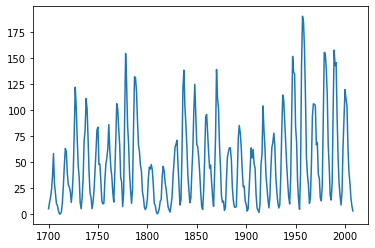

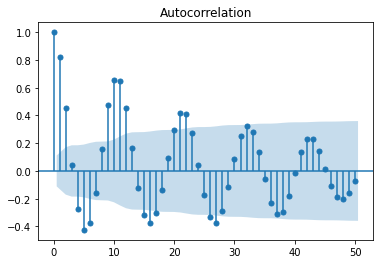

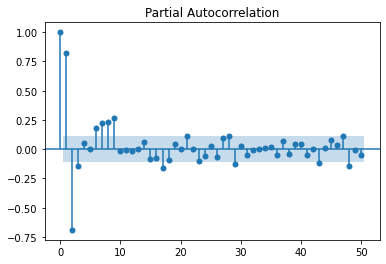

       YEAR  SUNACTIVITY
0    1700.0          5.0
1    1701.0         11.0
2    1702.0         16.0
3    1703.0         23.0
4    1704.0         36.0
..      ...          ...
304  2004.0         40.4
305  2005.0         29.8
306  2006.0         15.2
307  2007.0          7.5
308  2008.0          2.9

[309 rows x 2 columns]
                            OLS Regression Results                            
Dep. Variable:            SUNACTIVITY   R-squared:                       0.041
Model:                            OLS   Adj. R-squared:                  0.037
Method:                 Least Squares   F-statistic:                     10.48
Date:                Thu, 03 Feb 2022   Prob (F-statistic):            0.00137
Time:                        01:18:02   Log-Likelihood:                -1275.3
No. Observations:                 249   AIC:                             2555.
Df Residuals:                     247   BIC:                             2562.
Df Model:                           1       

/opt/homebrew/anaconda3/envs/COMP-3948/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


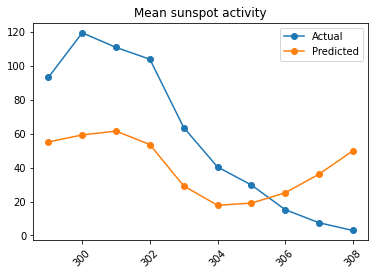

In [32]:
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Create back-shifted columns for an attribute.
def addBackShiftedColumns(df, colName, timeLags):
    for i in range(1, timeLags+1):
        newColName = colName + "_t-" + str(i)
        df[newColName] = df[colName].shift(i)
    return df


dta = sm.datasets.sunspots.load_pandas().data
print(dta)
plt.plot(dta['YEAR'], dta['SUNACTIVITY'])
plt.show()

# Show autocorrelation function.
# General correlation of lags with past lags.
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(dta['SUNACTIVITY'], lags=50)
plt.show()

# Show partial-autocorrelation function.
# Shows correlation of 1st lag with past lags.
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(dta['SUNACTIVITY'], lags=50)
plt.show()

print(dta)

# Build dataframe for modelling.
target_column = 'SUNACTIVITY'
modelDf = dta.copy()

NUM_TIME_STEPS = 50
for i in range(0, len(columns)):
    modelDf = addBackShiftedColumns(modelDf, columns[i],
                                    NUM_TIME_STEPS)
modelDf = modelDf.dropna()
y = modelDf[[target_column]]
X = modelDf['SUNACTIVITY_t-47']

# Add intercept for OLS regression.
X         = sm.add_constant(X)
TEST_DAYS = 10

# Split into test and train sets. The test data includes
# the latest values in the data.
lenData = len(X)
X_train = X[0:lenData-TEST_DAYS]
y_train = y[0:lenData-TEST_DAYS]
X_test  = X[lenData-TEST_DAYS:]
y_test  = y[lenData-TEST_DAYS:]

# Model and make predictions.
model       = sm.OLS(y_train, X_train).fit()
print(model.summary())
predictions = model.predict(X_test)

# Show RMSE.
from sklearn  import metrics
print('Root Mean Squared Error:',
      np.sqrt(metrics.mean_squared_error(y_test, predictions)))

# Plot the data.
xaxisValues = list(y_test.index)
plt.plot(xaxisValues, y_test, label='Actual', marker='o')
plt.plot(xaxisValues, predictions, label='Predicted', marker='o')
plt.xticks(rotation=45)
plt.legend(loc='best')
plt.title("Mean sunspot activity")
plt.show()

                  High         Low        Open       Close    Volume   Adj Close
Date                                                                            
2021-11-26  337.929993  328.119995  334.350006  329.679993  24217200  329.679993
2021-11-29  339.029999  334.739990  334.940002  336.630005  28563500  336.630005
2021-11-30  337.779999  328.989990  335.320007  330.589996  42885600  330.589996
2021-12-01  339.279999  329.390015  335.130005  330.079987  33337600  330.079987
2021-12-02  333.489990  327.799988  330.299988  329.489990  30766000  329.489990
2021-12-03  332.700012  318.029999  331.989990  323.010010  41755900  323.010010
2021-12-06  327.450012  319.230011  323.950012  326.190002  30032600  326.190002
2021-12-07  335.799988  330.100006  331.640015  334.920013  31021900  334.920013
2021-12-08  335.500000  330.799988  335.309998  334.970001  24761000  334.970001
2021-12-09  336.489990  332.119995  334.410004  333.100006  22214200  333.100006
2021-12-10  343.000000  334.

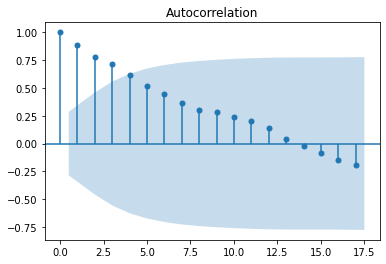

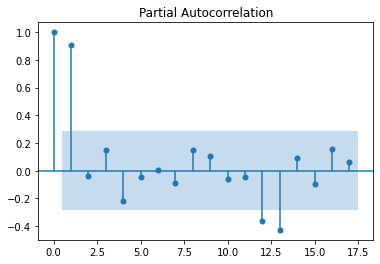

In [33]:
import numpy as np, pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
import datetime
import pandas_datareader as pdr

def getStock(stk, ttlDays):
    numDays = int(ttlDays)
    dt      = datetime.date.today()
    dtPast  = dt + datetime.timedelta(days=-numDays)
    df      = pdr.get_data_yahoo(stk,
                                 start   = datetime.datetime(dtPast.year, dtPast.month, dtPast.day),
                                 end     = datetime.datetime(dt.year, dt.month, dt.day))
    return df

NUM_DAYS = 70
df = getStock('MSFT', NUM_DAYS)
print(df)

# Plot ACF for stock.
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df['Open'])
plot_pacf(df['Open'])
plt.show()

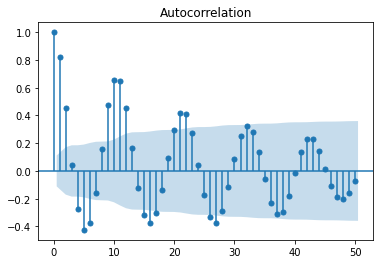

              YEAR  SUNACTIVITY
1999-12-31  1999.0         93.3
2000-12-31  2000.0        119.6
2001-12-31  2001.0        111.0
2002-12-31  2002.0        104.0
2003-12-31  2003.0         63.7
2004-12-31  2004.0         40.4
2005-12-31  2005.0         29.8
2006-12-31  2006.0         15.2
2007-12-31  2007.0          7.5
2008-12-31  2008.0          2.9

*** Evaluating ARMA(2,0,0)
Coefficients: const      49.728506
ar.L1       1.386171
ar.L2      -0.687217
sigma2    278.758454
dtype: float64
Test RMSE: 25.145
Model AIC 2542.401
Model BIC 2557.203

*** Evaluating ARMA(3,0,0)
Coefficients: const      49.767980
ar.L1       1.303286
ar.L2      -0.520229
ar.L3      -0.120298
sigma2    274.716657
dtype: float64
Test RMSE: 22.480
Model AIC 2540.073
Model BIC 2558.575

*** Evaluating ARMA(9,0,0)
Coefficients: const      49.450261
ar.L1       1.162713
ar.L2      -0.402611
ar.L3      -0.155085
ar.L4       0.141164
ar.L5      -0.092369
ar.L6       0.017273
ar.L7       0.037691
ar.L8      -0.066205
ar

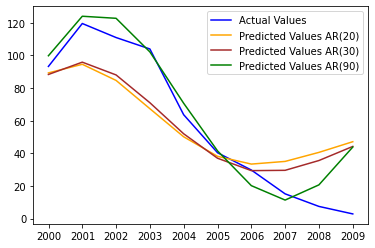


*** Comparing AR Model Time Steps
dict_values([              0
0   3174.049905
1   2830.369176
2   2637.569703
3   2638.070335
4   2642.878700
5   2648.610908
6   2645.594430
7   2635.308015
8   2625.737548
9   2611.689366
10  2617.421383, (9, 0)])


In [39]:
import  pandas as pd
import  matplotlib.pyplot as plt
import  statsmodels.api as sm
from    statsmodels.tsa.arima.model import ARIMA
from    sklearn.metrics import mean_squared_error
import  numpy as np
dta       = sm.datasets.sunspots.load_pandas().data
dta.index = pd.Index(sm.tsa.datetools.dates_from_range('1700', '2008'), freq='Y')

# Show autocorrelation function.
# General correlation of lags with past lags.
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(dta['SUNACTIVITY'], lags=50)
plt.show()

# Split the data.
NUM_TEST_YEARS = 10
lenData        = len(dta)
dfTrain        = dta.iloc[0:lenData - NUM_TEST_YEARS, :]
dfTest         = dta.iloc[lenData-NUM_TEST_YEARS:,:]

def buildModelAndMakePredictions(AR_time_steps, dfTrain, dfTest):
    # This week we will use the ARIMA model.

    model  = ARIMA(dfTrain['SUNACTIVITY'], order=(AR_time_steps, 0, 0),
                   freq='Y').fit()
    print("\n*** Evaluating ARMA(" + str(AR_time_steps) + ",0,0)")
    print('Coefficients: %s' %model.params)

    # Strings which can be converted to time stamps are passed in.
    # For this case the entire time range for the test set is represented.
    predictions = model.predict('1999-12-31', '2008-12-31', dynamic=True)
    rmse = np.sqrt(mean_squared_error(dfTest['SUNACTIVITY'].values,
                                      np.array(predictions)))
    print('Test RMSE: %.3f' % rmse)
    print('Model AIC %.3f' % model.aic)
    print('Model BIC %.3f' % model.bic)
    return model, predictions

print(dfTest)
arma_mod20, predictionsARMA_20 = buildModelAndMakePredictions(2, dfTrain, dfTest)
arma_mod30, predictionsARMA_30 = buildModelAndMakePredictions(3, dfTrain, dfTest)
arma_mod90, predictionsARMA_90 = buildModelAndMakePredictions(9, dfTrain, dfTest)
plt.plot(dfTest.index, dfTest['SUNACTIVITY'],
         label='Actual Values', color='blue')
plt.plot(dfTest.index, predictionsARMA_20,
         label='Predicted Values AR(20)', color='orange')
plt.plot(dfTest.index, predictionsARMA_30,
         label='Predicted Values AR(30)', color='brown')
plt.plot(dfTest.index, predictionsARMA_90,
         label='Predicted Values AR(90)', color='green')
plt.legend(loc='best')
plt.show()

print("\n*** Comparing AR Model Time Steps")
import warnings
warnings.filterwarnings("ignore")
res = sm.tsa.arma_order_select_ic(dta['SUNACTIVITY'], max_ar=10, max_ma=0, ic='bic')
print(res.values())


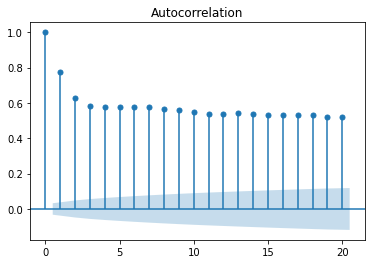

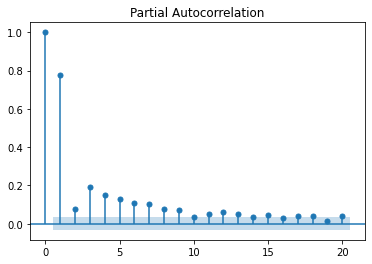

Coefficients: [ 1.88820768  0.70018223 -0.05949822  0.19010829]
                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                 3647
Model:                     AutoReg(3)   Log Likelihood               -8536.330
Method:               Conditional MLE   S.D. of innovations              2.518
Date:                Thu, 03 Feb 2022   AIC                              1.850
Time:                        17:57:55   BIC                              1.859
Sample:                             3   HQIC                             1.853
                                 3647                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.8882      0.134     14.098      0.000       1.626       2.151
y.L1           0.7002      0.016     43.057      0.000       0.668 

/opt/homebrew/anaconda3/envs/COMP-3948/lib/python3.9/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


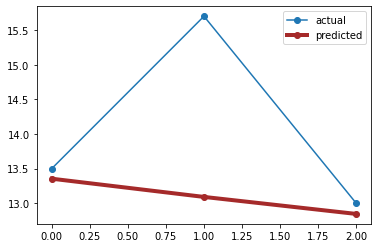

Here is a one week temperature forecast: 
[12.622916531000001, 12.937772818779445, 12.667373008683304]


In [2]:
from pandas                     import read_csv
import matplotlib.pyplot        as plt
from statsmodels.tsa.ar_model   import AutoReg
from sklearn.metrics            import mean_squared_error
from math                       import sqrt

# Load the data.
PATH = "../datasets/"
series = read_csv(PATH + 'daily-min-temperatures.csv',
                  header=0, index_col=0, parse_dates=True, squeeze=True)

# Plot ACF.
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(series, lags=20)
plt.show()

# Plot PACF.
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(series, lags=20)
plt.show()
NUM_TEST_DAYS = 3

# Split dataset into test and train.
X       = series.values
lenData = len(X)
train   = X[0:lenData-NUM_TEST_DAYS]
test    = X[lenData-NUM_TEST_DAYS:]

# Train.
model     = AutoReg(train, lags=3)
model_fit = model.fit()
print('Coefficients: %s' % model_fit.params)

print(model_fit.summary())

# Make predictions.
predictions = model_fit.predict(start=len(train),
                                end=len(train)+len(test)-1,
                                dynamic=False)

for i in range(len(predictions)):
    print('predicted=%f, expected=%f' % (predictions[i], test[i]))
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

# Plot results.
plt.plot(test, marker='o', label='actual')
plt.plot(predictions, color='brown', linewidth=4,
         marker='o', label='predicted')

plt.legend()
plt.show()

# Use model coefficients from autoregression to make a prediction.
def makePrediction(t_1, t_2, t_3):
    intercept =   1.88820768
    t1Coeff   =   0.70018223
    t2Coeff   = - 0.05949822
    t3Coeff   =   0.19010829

    prediction = intercept + t1Coeff*t_1 + t2Coeff*t_2 + t3Coeff*t_3
    return prediction

testLen    = len(test)

t_1 = test[testLen-1]
t_2 = test[testLen-2]
t_3 = test[testLen-3]

futurePredictions = []
for i in range(0, NUM_TEST_DAYS):
    prediction = makePrediction(t_1, t_2, t_3)
    futurePredictions.append(prediction)
    t_3 = t_2
    t_2 = t_1
    t_1 = prediction

print("Here is a one week temperature forecast: ")
print(futurePredictions)


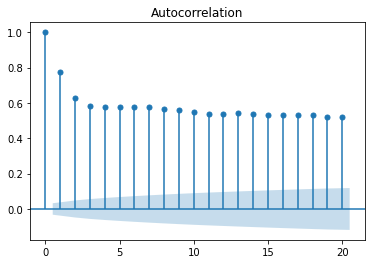

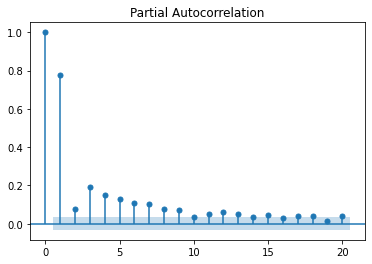

Coefficients: [ 1.11532391  0.62644214 -0.07506915  0.07390916  0.06186014  0.06587204
  0.04415531  0.10268948]
                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                 3643
Model:                     AutoReg(7)   Log Likelihood               -8405.358
Method:               Conditional MLE   S.D. of innovations              2.442
Date:                Wed, 09 Feb 2022   AIC                              1.790
Time:                        17:06:36   BIC                              1.806
Sample:                             7   HQIC                             1.796
                                 3643                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.1153      0.139      8.006      0.000       0.842       1.388
y.L1           0.6

/opt/homebrew/anaconda3/envs/COMP-3948/lib/python3.9/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


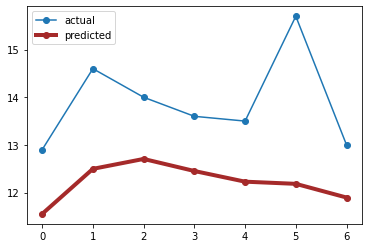

Here is a one week temperature forecast: 
[12.812194310000002, 13.17633492920627, 13.268217490062451, 13.217617916082077, 13.103006446480094, 13.159150818011913, 12.942602622239761]


In [1]:
from pandas                     import read_csv
import matplotlib.pyplot        as plt
from statsmodels.tsa.ar_model   import AutoReg
from sklearn.metrics            import mean_squared_error
from math                       import sqrt

# Load the data.
PATH = "../datasets/"
series = read_csv(PATH + 'daily-min-temperatures.csv',
                  header=0, index_col=0, parse_dates=True, squeeze=True)

# Plot ACF.
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(series, lags=20)
plt.show()

# Plot PACF.
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(series, lags=20)
plt.show()

NUM_TEST_DAYS = 7

# Split dataset into test and train.
X       = series.values
lenData = len(X)
train   = X[0:lenData-NUM_TEST_DAYS]
test    = X[lenData-NUM_TEST_DAYS:]

# Train.
model     = AutoReg(train, lags=7)
model_fit = model.fit()
print('Coefficients: %s' % model_fit.params)

print(model_fit.summary())

# Make predictions.
predictions = model_fit.predict(start=len(train),
                                end=len(train)+len(test)-1,
                                dynamic=False)

for i in range(len(predictions)):
    print('predicted=%f, expected=%f' % (predictions[i], test[i]))
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

# Plot results.
plt.plot(test, marker='o', label='actual')
plt.plot(predictions, color='brown', linewidth=4,
         marker='o', label='predicted')

plt.legend()
plt.show()


# Use model coefficients from autoregression to make a prediction.
def makePrediction(t_1, t_2, t_3, t_4, t_5, t_6, t_7):
    intercept =   1.11419079
    t1Coeff   =   0.62630048
    t2Coeff   =  -0.07514724
    t3Coeff   =   0.07405114
    t4Coeff   =   0.06167809
    t5Coeff   =   0.06602607
    t6Coeff   =   0.04416757
    t7Coeff   =   0.10296008

    prediction = intercept + t1Coeff*t_1 + t2Coeff*t_2 + t3Coeff*t_3 + t4Coeff*t_4 + t5Coeff*t_5 + t6Coeff*t_6 + t7Coeff*t_7
    return prediction

testLen = len(test)

t_1 = test[testLen-1]
t_2 = test[testLen-2]
t_3 = test[testLen-3]
t_4 = test[testLen-4]
t_5 = test[testLen-5]
t_6 = test[testLen-6]
t_7 = test[testLen-7]

futurePredictions = []
for i in range(0, NUM_TEST_DAYS):
    prediction = makePrediction(t_1, t_2, t_3, t_4, t_5, t_6, t_7)
    futurePredictions.append(prediction)
    t_7 = t_6
    t_6 = t_5
    t_5 = t_4
    t_4 = t_3
    t_3 = t_2
    t_2 = t_1
    t_1 = prediction

print("Here is a one week temperature forecast: ")
print(futurePredictions)